In [2]:
# 0. Imports & global settings
import os
from pathlib import Path
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import sklearn
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize

# Reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Display settings
%matplotlib inline
plt.rcParams['figure.figsize'] = (8,5)
sns.set_style("whitegrid")


# Project Title: [Write your project name here]
**Objective:** Briefly describe the objective (what to predict and why).  
**Dataset layout:** A root folder with `train/`, `val/`, `test/`. Each of those contains subfolders — one per class, containing images.

**Notebook outline**
1. Dataset loading
2. EDA
3. Preprocessing / Augmentation
4. Model building (CNN + Transfer Learning)
5. Training
6. Evaluation
7. Results & Insights
8. Conclusion & Future Work
9. Save & Inference


In [3]:
# 2. Dataset Loading - set your dataset path here
DATA_DIR = Path("D:\INTERNSHIP LABMENTIX\PROJECT 4 (3RD AUGUST TO 10 TH AUGUST)\DATASET\data")  # <-- CHANGE this
train_dir = DATA_DIR / "train"
val_dir   = DATA_DIR / "val"
test_dir  = DATA_DIR / "test"

assert train_dir.exists(), f"Train folder not found at {train_dir}"
assert val_dir.exists(), f"Val folder not found at {val_dir}"
assert test_dir.exists(), f"Test folder not found at {test_dir}"

# Print basic checks
def list_classes(folder):
    return sorted([p.name for p in Path(folder).iterdir() if p.is_dir()])

print("Train exists:", train_dir.exists())
print("Val exists:  ", val_dir.exists())
print("Test exists: ", test_dir.exists())
print("Classes (train):", list_classes(train_dir))


Train exists: True
Val exists:   True
Test exists:  True
Classes (train): ['animal fish', 'animal fish bass', 'fish sea_food black_sea_sprat', 'fish sea_food gilt_head_bream', 'fish sea_food hourse_mackerel', 'fish sea_food red_mullet', 'fish sea_food red_sea_bream', 'fish sea_food sea_bass', 'fish sea_food shrimp', 'fish sea_food striped_red_mullet', 'fish sea_food trout']


<>:2: SyntaxWarning: invalid escape sequence '\I'
<>:2: SyntaxWarning: invalid escape sequence '\I'
C:\Users\nimis\AppData\Local\Temp\ipykernel_24900\1668011190.py:2: SyntaxWarning: invalid escape sequence '\I'
  DATA_DIR = Path("D:\INTERNSHIP LABMENTIX\PROJECT 4 (3RD AUGUST TO 10 TH AUGUST)\DATASET\data")  # <-- CHANGE this


Train counts: {'animal fish': 1096, 'animal fish bass': 30, 'fish sea_food black_sea_sprat': 569, 'fish sea_food gilt_head_bream': 566, 'fish sea_food hourse_mackerel': 573, 'fish sea_food red_mullet': 579, 'fish sea_food red_sea_bream': 571, 'fish sea_food sea_bass': 538, 'fish sea_food shrimp': 576, 'fish sea_food striped_red_mullet': 547, 'fish sea_food trout': 580}
Val counts: {'animal fish': 187, 'animal fish bass': 10, 'fish sea_food black_sea_sprat': 105, 'fish sea_food gilt_head_bream': 94, 'fish sea_food hourse_mackerel': 97, 'fish sea_food red_mullet': 90, 'fish sea_food red_sea_bream': 113, 'fish sea_food sea_bass': 97, 'fish sea_food shrimp': 100, 'fish sea_food striped_red_mullet': 101, 'fish sea_food trout': 98}
Test counts: {'animal fish': 495, 'animal fish bass': 13, 'fish sea_food black_sea_sprat': 298, 'fish sea_food gilt_head_bream': 305, 'fish sea_food hourse_mackerel': 286, 'fish sea_food red_mullet': 291, 'fish sea_food red_sea_bream': 273, 'fish sea_food sea_bass

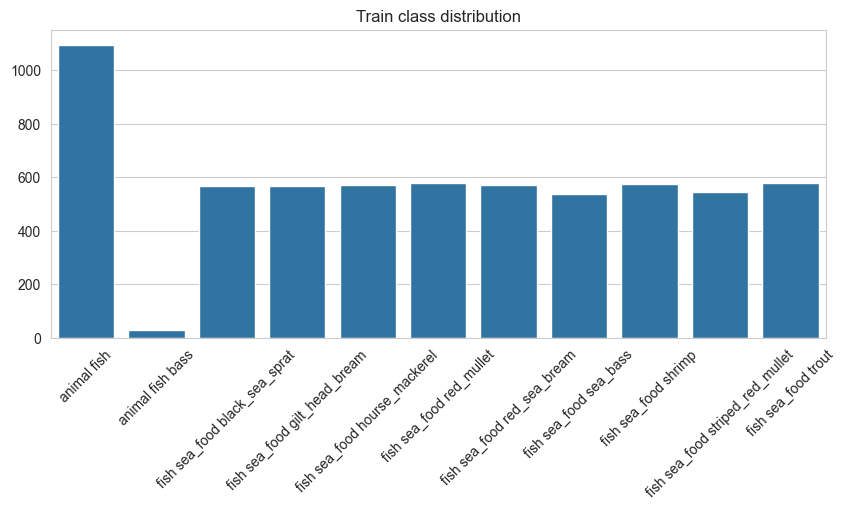

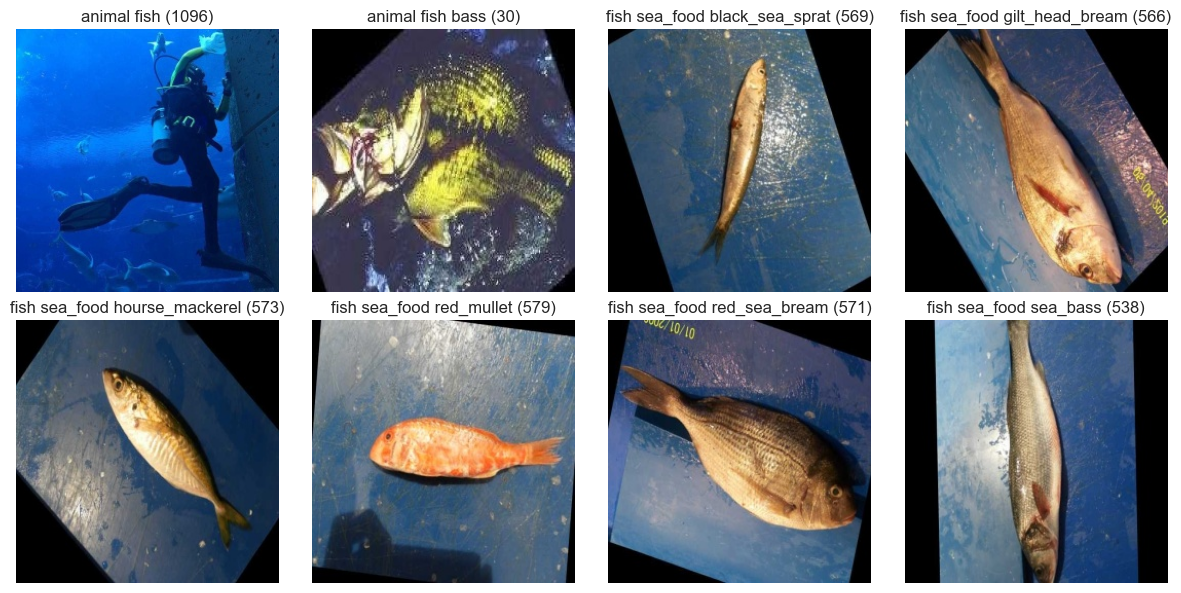

Sample unique image sizes (w,h) : [[256 256]]


In [4]:
# 3. EDA - class distribution, sample images, image size checks
def class_counts(folder):
    d = {}
    for cls in sorted([p.name for p in Path(folder).iterdir() if p.is_dir()]):
        d[cls] = sum(1 for _ in (Path(folder)/cls).iterdir())
    return d

train_counts = class_counts(train_dir)
val_counts = class_counts(val_dir)
test_counts = class_counts(test_dir)

print("Train counts:", train_counts)
print("Val counts:", val_counts)
print("Test counts:", test_counts)

# Bar plot for train distribution
plt.figure(figsize=(10,4))
sns.barplot(x=list(train_counts.keys()), y=list(train_counts.values()))
plt.xticks(rotation=45)
plt.title("Train class distribution")
plt.show()

# Show sample images (one per class)
sample_classes = list(train_counts.keys())[:8]
plt.figure(figsize=(12,6))
for i, cls in enumerate(sample_classes,1):
    img_path = next((Path(train_dir)/cls).iterdir())
    img = Image.open(img_path)
    plt.subplot(2,4,i)
    plt.imshow(img)
    plt.title(f"{cls} ({train_counts[cls]})")
    plt.axis('off')
plt.tight_layout()
plt.show()

# Quick image size distribution (first 200 images)
sizes = []
for i, p in enumerate(Path(train_dir).rglob("*.*")):
    if i>=200: break
    try:
        with Image.open(p) as im:
            sizes.append(im.size)
    except:
        continue
if sizes:
    sizes_arr = np.array(sizes)
    uniq = np.unique(sizes_arr, axis=0)
    print("Sample unique image sizes (w,h) :", uniq[:10])


In [5]:
# 4. Data Preprocessing: ImageDataGenerator (on-the-fly augmentation)
IMG_SIZE = (224, 224)     # change to 128, 224, 299 as needed
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.10,
    height_shift_range=0.10,
    shear_range=0.05,
    zoom_range=0.10,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=True, seed=SEED
)

val_gen = val_datagen.flow_from_directory(
    val_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False, seed=SEED
)

test_gen = test_datagen.flow_from_directory(
    test_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False, seed=SEED
)

NUM_CLASSES = train_gen.num_classes
CLASS_INDICES = train_gen.class_indices
INV_CLASS_MAP = {v:k for k,v in CLASS_INDICES.items()}

print("Num classes:", NUM_CLASSES)
print("Class indices:", CLASS_INDICES)


Found 6225 images belonging to 11 classes.
Found 1092 images belonging to 11 classes.
Found 3162 images belonging to 11 classes.
Num classes: 11
Class indices: {'animal fish': 0, 'animal fish bass': 1, 'fish sea_food black_sea_sprat': 2, 'fish sea_food gilt_head_bream': 3, 'fish sea_food hourse_mackerel': 4, 'fish sea_food red_mullet': 5, 'fish sea_food red_sea_bream': 6, 'fish sea_food sea_bass': 7, 'fish sea_food shrimp': 8, 'fish sea_food striped_red_mullet': 9, 'fish sea_food trout': 10}


In [6]:
# 5A. Simple CNN model
from tensorflow.keras.optimizers import Adam

def build_simple_cnn(input_shape=(*IMG_SIZE,3), num_classes=NUM_CLASSES):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(32,(3,3),activation='relu',padding='same')(inputs)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64,(3,3),activation='relu',padding='same')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(128,(3,3),activation='relu',padding='same')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128,activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs, outputs, name='simple_cnn')
    model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

simple_cnn = build_simple_cnn()
simple_cnn.summary()


Model: "simple_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 11)             │         1,419 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,179 (434.29 KB)

 Trainable params: 111,179 (434.29 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# 5B. Transfer Learning - VGG16 as example
from tensorflow.keras.applications import VGG16
from tensorflow.keras import Model

def build_vgg16_transfer(input_shape=(*IMG_SIZE,3), num_classes=NUM_CLASSES, base_trainable=False):
    base = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
    base.trainable = base_trainable  # False -> freeze
    x = base.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = Model(base.input, outputs, name='vgg16_transfer')
    model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

vgg_model = build_vgg16_transfer(base_trainable=False)
vgg_model.summary()


Model: "vgg16_transfer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 11)             │         2,827 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,848,843 (56.64 MB)

 Trainable params: 134,155 (524.04 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [8]:
# 6. Training
EPOCHS = 15
checkpoint_path = "/mnt/data/best_model.h5"

callbacks = [
    EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-7, verbose=1),
    ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
]

# Choose model to train:
model = vgg_model  # or simple_cnn

history = model.fit(
    train_gen,
    epochs=EPOCHS,
    validation_data=val_gen,
    callbacks=callbacks
)


C:\Users\nimis\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1398 - loss: 2.4659
Epoch 1: val_loss improved from inf to 1.98739, saving model to /mnt/data/best_model.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 378s 2s/step - accuracy: 0.1400 - loss: 2.4651 - val_accuracy: 0.3626 - val_loss: 1.9874 - learning_rate: 1.0000e-04
Epoch 2/15
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3137 - loss: 2.0009
Epoch 2: val_loss improved from 1.98739 to 1.73601, saving model to /mnt/data/best_model.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 367s 2s/step - accuracy: 0.3139 - loss: 2.0005 - val_accuracy: 0.6081 - val_loss: 1.7360 - learning_rate: 1.0000e-04
Epoch 3/15
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4372 - loss: 1.7495
Epoch 3: val_loss improved from 1.73601 to 1.55035, saving model to /mnt/data/best_model.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 372s 2s/step - accuracy: 0.4374 - loss: 1.7493 - val_accuracy: 0.6630 - val_loss: 1.5503 - learning_rate: 1.0000e-04
Epoch 4/15
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5549 - loss: 1.5577
Epoch 4: val_loss improved from 1.55035 to 1.39219, saving model to /mnt/data/best_model.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 370s 2s/step - accuracy: 0.5550 - loss: 1.5575 - val_accuracy: 0.6859 - val_loss: 1.3922 - learning_rate: 1.0000e-04
Epoch 5/15
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6233 - loss: 1.3960
Epoch 5: val_loss improved from 1.39219 to 1.26589, saving model to /mnt/data/best_model.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 361s 2s/step - accuracy: 0.6233 - loss: 1.3959 - val_accuracy: 0.6960 - val_loss: 1.2659 - learning_rate: 1.0000e-04
Epoch 6/15
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6579 - loss: 1.2814
Epoch 6: val_loss improved from 1.26589 to 1.14589, saving model to /mnt/data/best_model.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 377s 2s/step - accuracy: 0.6579 - loss: 1.2813 - val_accuracy: 0.7262 - val_loss: 1.1459 - learning_rate: 1.0000e-04
Epoch 7/15
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6874 - loss: 1.1823
Epoch 7: val_loss improved from 1.14589 to 1.05172, saving model to /mnt/data/best_model.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 372s 2s/step - accuracy: 0.6875 - loss: 1.1821 - val_accuracy: 0.7592 - val_loss: 1.0517 - learning_rate: 1.0000e-04
Epoch 8/15
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7167 - loss: 1.0808
Epoch 8: val_loss improved from 1.05172 to 0.96574, saving model to /mnt/data/best_model.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 368s 2s/step - accuracy: 0.7167 - loss: 1.0808 - val_accuracy: 0.7912 - val_loss: 0.9657 - learning_rate: 1.0000e-04
Epoch 9/15
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7494 - loss: 0.9945
Epoch 9: val_loss improved from 0.96574 to 0.90048, saving model to /mnt/data/best_model.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 367s 2s/step - accuracy: 0.7494 - loss: 0.9945 - val_accuracy: 0.7967 - val_loss: 0.9005 - learning_rate: 1.0000e-04
Epoch 10/15
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7471 - loss: 0.9378
Epoch 10: val_loss improved from 0.90048 to 0.83305, saving model to /mnt/data/best_model.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 365s 2s/step - accuracy: 0.7472 - loss: 0.9377 - val_accuracy: 0.8159 - val_loss: 0.8331 - learning_rate: 1.0000e-04
Epoch 11/15
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7706 - loss: 0.8844
Epoch 11: val_loss improved from 0.83305 to 0.78488, saving model to /mnt/data/best_model.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 372s 2s/step - accuracy: 0.7706 - loss: 0.8844 - val_accuracy: 0.8159 - val_loss: 0.7849 - learning_rate: 1.0000e-04
Epoch 12/15
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7956 - loss: 0.8021
Epoch 12: val_loss improved from 0.78488 to 0.72989, saving model to /mnt/data/best_model.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 341s 2s/step - accuracy: 0.7956 - loss: 0.8021 - val_accuracy: 0.8333 - val_loss: 0.7299 - learning_rate: 1.0000e-04
Epoch 13/15
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8013 - loss: 0.7850
Epoch 13: val_loss improved from 0.72989 to 0.68547, saving model to /mnt/data/best_model.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 342s 2s/step - accuracy: 0.8013 - loss: 0.7849 - val_accuracy: 0.8425 - val_loss: 0.6855 - learning_rate: 1.0000e-04
Epoch 14/15
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8105 - loss: 0.7331
Epoch 14: val_loss improved from 0.68547 to 0.65128, saving model to /mnt/data/best_model.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 339s 2s/step - accuracy: 0.8105 - loss: 0.7330 - val_accuracy: 0.8516 - val_loss: 0.6513 - learning_rate: 1.0000e-04
Epoch 15/15
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8132 - loss: 0.6876
Epoch 15: val_loss improved from 0.65128 to 0.61621, saving model to /mnt/data/best_model.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 339s 2s/step - accuracy: 0.8132 - loss: 0.6876 - val_accuracy: 0.8590 - val_loss: 0.6162 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 15.


99/99 ━━━━━━━━━━━━━━━━━━━━ 203s 2s/step
Classification Report:
                                  precision    recall  f1-score   support

                     animal fish       0.97      0.98      0.97       495
                animal fish bass       0.00      0.00      0.00        13
   fish sea_food black_sea_sprat       0.85      0.92      0.88       298
   fish sea_food gilt_head_bream       0.92      0.76      0.84       305
   fish sea_food hourse_mackerel       0.68      0.98      0.80       286
        fish sea_food red_mullet       0.80      0.68      0.73       291
     fish sea_food red_sea_bream       0.95      0.86      0.90       273
          fish sea_food sea_bass       0.91      0.83      0.87       327
            fish sea_food shrimp       0.81      1.00      0.89       289
fish sea_food striped_red_mullet       0.72      0.60      0.65       293
             fish sea_food trout       0.96      0.95      0.95       292

                        accuracy               

c:\Users\nimis\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\nimis\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\nimis\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


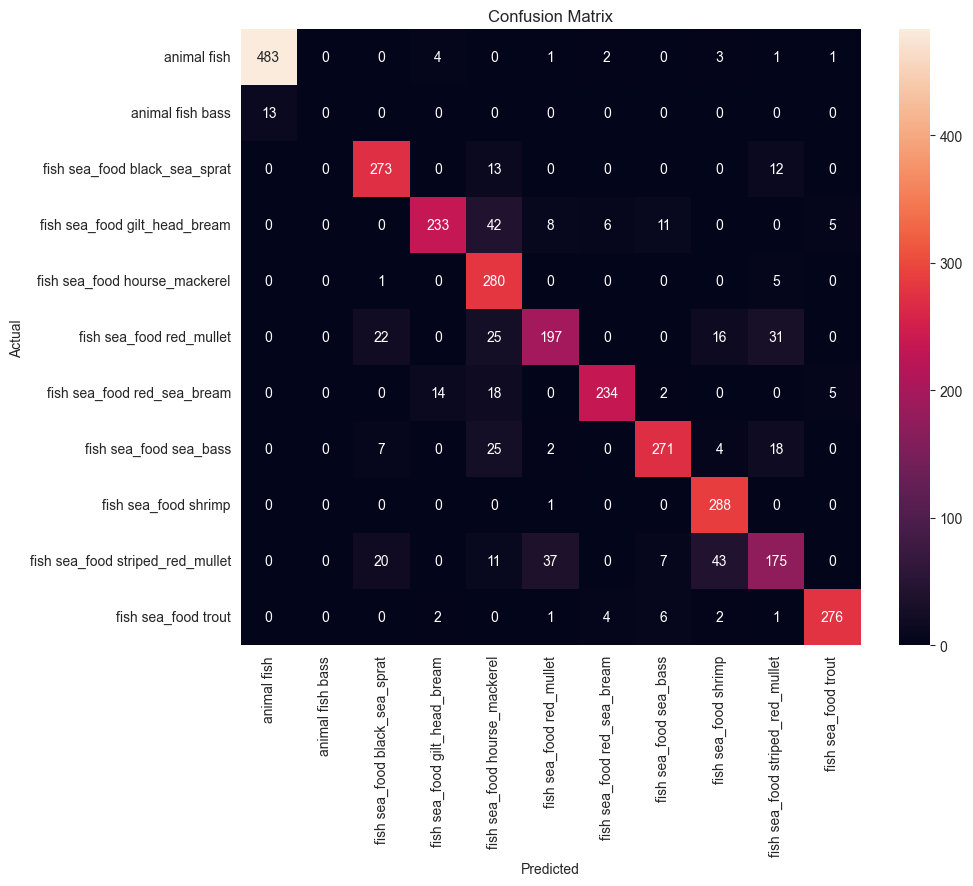

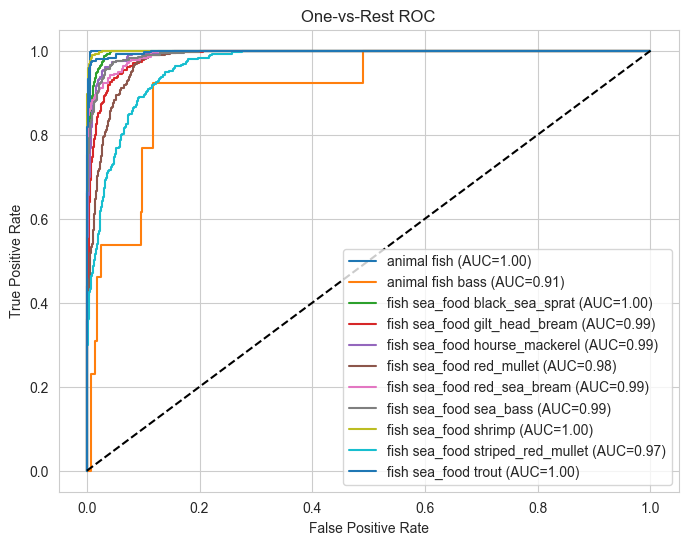

In [9]:
# 7. Evaluation on test set
# Predict probabilities
test_steps = int(np.ceil(test_gen.samples / test_gen.batch_size))
y_prob = model.predict(test_gen, steps=test_steps, verbose=1)
y_pred = np.argmax(y_prob, axis=1)
y_true = test_gen.classes[:len(y_pred)]

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=list(CLASS_INDICES.keys())))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=list(CLASS_INDICES.keys()), yticklabels=list(CLASS_INDICES.keys()))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# ROC curves (one-vs-rest) and AUC per class - only if NUM_CLASSES > 1
if NUM_CLASSES > 1:
    y_true_bin = label_binarize(y_true, classes=list(range(NUM_CLASSES)))
    plt.figure(figsize=(8,6))
    for i in range(NUM_CLASSES):
        fpr, tpr, _ = roc_curve(y_true_bin[:,i], y_prob[:,i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{INV_CLASS_MAP[i]} (AUC={roc_auc:.2f})")
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("One-vs-Rest ROC")
    plt.legend(loc='lower right')
    plt.show()


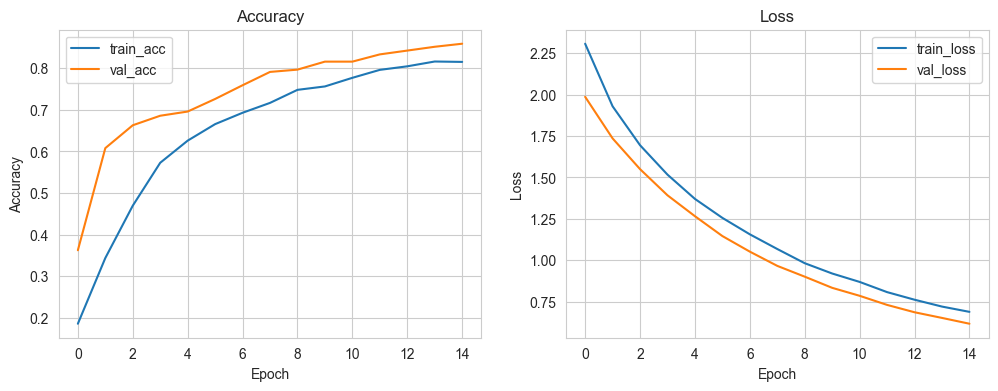

Final train acc (last epoch): 0.8152610659599304
Final val acc (last epoch): 0.8589743375778198


In [10]:
# 8. Results & Insights - plot training history
def plot_history(history):
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(history.history.get('accuracy', []), label='train_acc')
    plt.plot(history.history.get('val_accuracy', []), label='val_acc')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Accuracy")

    plt.subplot(1,2,2)
    plt.plot(history.history.get('loss', []), label='train_loss')
    plt.plot(history.history.get('val_loss', []), label='val_loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Loss")
    plt.show()

plot_history(history)

# Quick insights (edit as you observe actual numbers)
train_acc = history.history.get('accuracy', [])[-1] if history else None
val_acc = history.history.get('val_accuracy', [])[-1] if history else None
print(f"Final train acc (last epoch): {train_acc}")
print(f"Final val acc (last epoch): {val_acc}")

# Add your observations here as markdown after inspecting metrics:
# - Which classes are confused often?
# - Does validation loss/accuracy diverge (overfitting)?
# - Suggestions: more augmentation, class rebalancing, larger model, ensemble, fine-tuning.


In [11]:
# 9. Save final model and class mapping in dataset folder
final_model_path = r"D:\INTERNSHIP LABMENTIX\PROJECT 4 (3RD AUGUST TO 10 TH AUGUST)\DATASET\data\final_model.h5"
class_indices_path = r"D:\INTERNSHIP LABMENTIX\PROJECT 4 (3RD AUGUST TO 10 TH AUGUST)\DATASET\data\class_indices.json"

model.save(final_model_path)
with open(class_indices_path, "w") as f:
    json.dump(CLASS_INDICES, f)

print(f"Saved model to: {final_model_path}")
print(f"Saved class mapping to: {class_indices_path}")


Saved model to: D:\INTERNSHIP LABMENTIX\PROJECT 4 (3RD AUGUST TO 10 TH AUGUST)\DATASET\data\final_model.h5
Saved class mapping to: D:\INTERNSHIP LABMENTIX\PROJECT 4 (3RD AUGUST TO 10 TH AUGUST)\DATASET\data\class_indices.json


In [13]:
# 10. Inference example - single image prediction
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import json

# Paths for model and class mapping
final_model_path = r"D:\INTERNSHIP LABMENTIX\PROJECT 4 (3RD AUGUST TO 10 TH AUGUST)\DATASET\data\final_model.h5"
class_indices_path = r"D:\INTERNSHIP LABMENTIX\PROJECT 4 (3RD AUGUST TO 10 TH AUGUST)\DATASET\data\class_indices.json"

# Load saved model
loaded_model = load_model(final_model_path)

# Load class mapping
with open(class_indices_path, "r") as f:
    class_map = json.load(f)
inv_map = {int(v): k for k, v in class_map.items()}

def predict_image(img_path, model=loaded_model, target_size=IMG_SIZE):
    img = image.load_img(img_path, target_size=target_size)
    x = image.img_to_array(img) / 255.0
    x = np.expand_dims(x, axis=0)
    probs = model.predict(x)[0]
    idx = np.argmax(probs)
    return {
        "predicted_class": inv_map[idx],
        "confidence": float(probs[idx]),
        "all_probs": probs.tolist()
    }

# Example usage:
result = predict_image(r"D:\INTERNSHIP LABMENTIX\PROJECT 4 (3RD AUGUST TO 10 TH AUGUST)\TEST IMAGE.jpg")
print(result)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
{'predicted_class': 'animal fish', 'confidence': 0.9743502140045166, 'all_probs': [0.9743502140045166, 0.013349984772503376, 2.3320530090131797e-05, 0.0012926700292155147, 8.919609535951167e-05, 0.0010812609689310193, 0.0001697372499620542, 0.0001421614724677056, 0.008072085678577423, 0.0005393405444920063, 0.0008900214452296495]}


## Conclusion & Future Work
**Conclusion:** Summarize final performance, main strengths/weaknesses of the chosen approach.  
**Future work / improvements:**
- Fine-tune pretrained backbones (unfreeze layers progressively).
- Experiment with EfficientNet / ResNet architectures.
- Class rebalancing (weighted loss) or oversampling if class imbalance observed.
- Ensemble multiple architectures or use cross validation.
- Convert to TF SavedModel or TFLite for deployment, or build a Streamlit/Flask UI.


GITHUB LINK